In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#Didn't use os.mkdir here because I was a bit lazy... :(

class CsvImgSet:

    def __init__(self):
        self.X = np.loadtxt('../Data/handwritten/handwritten_digits_images.csv', delimiter=',', dtype=np.uint8)
        self.y = np.loadtxt('../Data/handwritten/handwritten_digits_labels.csv', delimiter=',', dtype=np.uint8)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]


def save_image(i, img, path, f):
    # print(type(img))
    img = Image.fromarray(img, 'L')
    img.save(path + str(i) + '/' + str(f) + '.png')

def write_to_folders():
    csvImgSet = CsvImgSet()
    path = ["../Data/MNIST/train/", "../Data/MNIST/val/", "../Data/MNIST/test/"]
    zero_to_nine = [[] for i in range(10)]
    n_samples = len(csvImgSet)
    for i in range(n_samples):
        zero_to_nine[csvImgSet[i][1]].append(csvImgSet[i][0].reshape(28, 28))

    for i in range(10):
        n_samples = len(zero_to_nine[i])
        f = 0
        for j in range(n_samples):
            save_image(i, zero_to_nine[i][j], path[f], j)
            if j >= int(n_samples*0.85):
                break
            elif j >= int(n_samples*0.7):
                f = 1

In [3]:

print(torch.cuda.is_available())

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

path = "../Data/MNIST/"

True


In [4]:
preprocessor = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

Task 6:

The dataloader is a great tool to split the data into batches, assign nr of processors, and I think only load
parts of the data a a time(batches). Other than that they are easy to use.


In [5]:
def get_data():
    train_set = datasets.ImageFolder(path+'train/', transform=preprocessor)
    val_set = datasets.ImageFolder(path+'val/', transform=preprocessor)
    test_set = datasets.ImageFolder(path+'test/', transform=preprocessor)
    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    val_loader = DataLoader(dataset=val_set, batch_size=128, num_workers=2, drop_last=True)
    test_loader = DataLoader(dataset=test_set, batch_size=64, num_workers=2, drop_last=True)
    return train_loader, val_loader, test_loader

In [6]:
train, val, test = get_data()
trainiter = iter(train)
nex = next(trainiter)


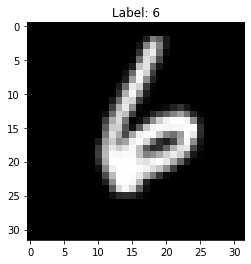

In [7]:

img = nex[0][0].numpy().reshape(32, 32, 1)
plt.title('Label: ' + str(nex[1][0].item()))
plt.imshow(img, cmap='gray')

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    out = model(xb)
    loss = loss_func(out, yb)
    preds = torch.argmax(out, dim=1)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), (preds == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, test_dl):
    accuracy_plot = []
    loss_plot = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-'*10)
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums, accuracy = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in valid_dl])

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        accuracy = np.sum(accuracy)/len(accuracy)
        print("Accuracy: " + str(accuracy.item()))
        accuracy_plot.append(accuracy)
        loss_plot.append(val_loss)
        print('Epoch: ' + str(epoch+1) + ' loss: ' + str(val_loss) + '\n')

    model.eval()
    with torch.no_grad():
        losses, nums, accuracy = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in test_dl])

    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    accuracy = np.sum(accuracy)/len(accuracy)
    print("Test accuracy: " + str(accuracy.item()))
    print('Test loss: ' + str(val_loss) + '\n')
    return accuracy_plot, loss_plot

def test_single_batch(epochs, model, loss_func, opt, xb, yb):
    #Used to test if model is able to overfit a single batch, to see if the model is working.
    for epoch in range(epochs):
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
        model.train()

        xb = xb.to(dev)
        yb = yb.to(dev)
        loss_batch(model, loss_func, xb, yb, opt)

        if (epoch+1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                losses, nums, accuracy  = loss_batch(model, loss_func, xb, yb)
                print("Accuracy: " + str(accuracy.item()) + ' loss: '
                      + str(np.sum(np.multiply(losses, nums)) / np.sum(nums)) + '\n')


In [9]:

class ViewLayer(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

model = torch.nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    ViewLayer(lambda x: x.view(x.size(0), -1)),
)

In [10]:
loss_func = torch.nn.CrossEntropyLoss()
model.to(dev)

# used for testing if model is working:
# xb, yb = trainiter.next()
# test_single_batch(1000, model, loss_func, opt, xb, yb)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (8): ViewLayer()
)

In [11]:

optimizers = [torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
              torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
              torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
              torch.optim.Adam(model.parameters(), lr=0.001),
              torch.optim.Adam(model.parameters(), lr=0.01),
              torch.optim.Adam(model.parameters(), lr=0.1)]
lrs = [0.001, 0.01, 0.1, 0.001, 0.01, 0.1]
opts = ['SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam']
l_plots = []
a_plots = []
for opt in optimizers:
    a_plot, l_plot = fit(10, model, loss_func, opt, train, val, test)
    l_plots.append(l_plot)
    a_plots.append(a_plot)

Epoch 1/10
----------
Accuracy: 0.11261432617902756
Epoch: 1 loss: 2.2900842922489817

Epoch 2/10
----------
Accuracy: 0.11985518038272858
Epoch: 2 loss: 2.2740355700981327

Epoch 3/10
----------
Accuracy: 0.19912347197532654
Epoch: 3 loss: 2.23707234423335

Epoch 4/10
----------
Accuracy: 0.33917680382728577
Epoch: 4 loss: 2.0586150404883594

Epoch 5/10
----------
Accuracy: 0.4135861098766327
Epoch: 5 loss: 1.7058126243149363

Epoch 6/10
----------
Accuracy: 0.5272484421730042
Epoch: 6 loss: 1.469348397923679

Epoch 7/10
----------
Accuracy: 0.6205220818519592
Epoch: 7 loss: 1.2708387912773504

Epoch 8/10
----------
Accuracy: 0.6239519715309143
Epoch: 8 loss: 1.178842428253918

Epoch 9/10
----------
Accuracy: 0.6626333594322205
Epoch: 9 loss: 1.0834916626534812

Epoch 10/10
----------
Accuracy: 0.703410804271698
Epoch: 10 loss: 0.9819904522198003

Test accuracy: 0.7009202241897583
Test loss: 0.9818537451921066

Epoch 1/10
----------
Accuracy: 0.7940167188644409
Epoch: 1 loss: 0.689188

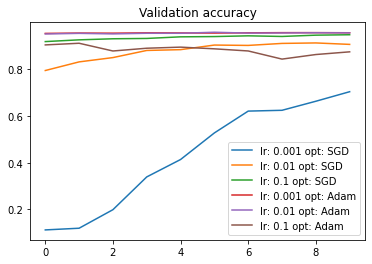

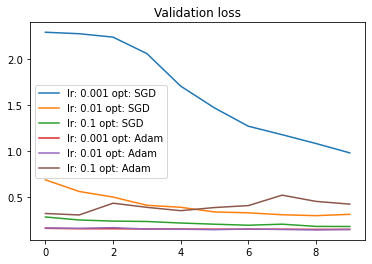

In [12]:
for i in range(len(a_plots)):
    plt.plot(a_plots[i], label="lr: " + str(lrs[i]) + " opt: "+ opts[i])
plt.legend()
plt.title("Validation accuracy")
plt.show()
plt.pause(0.01)
for i in range(len(l_plots)):
    plt.plot(l_plots[i], label="lr: " + str(lrs[i]) + " opt: "+ opts[i])
plt.legend()
plt.title("Validation loss")
plt.show()